In [1]:
import numpy as np
import pandas as pd 
import re
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")
# import nltk
# import spacy                                       ## pip install -U spacy
# from nltk.tokenize.toktok import ToktokTokenizer
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt

In [2]:
from nltk.cluster import KMeansClusterer
import nltk
from sklearn.manifold import TSNE

In [3]:
from sklearn.cluster import KMeans

In [4]:
import numpy as np
import seaborn as sns

In [5]:
data = pd.read_csv('fbportal_new.csv')
data.head()

,Test Case Description,Label
0,What's the weather like in Chicago?,Weather
1,What is the forecast in Tampa for tomorrow?,Weather
2,What is the weather in Oregon today?,Weather
3,Is it raining in France right now?,Weather
4,Show me the weather in Mexico for next week.,Weather


In [6]:
data.shape

(827, 2)

In [6]:
def text_cleaner(text):
   
    newString = text.lower()
    newString = re.sub(r"pre-conditions:","",newString)
    newString = re.sub(r"precondition:","",newString)
    newString = re.sub(r"hey","",newString)
    newString = re.sub(r"portal","",newString)
    newString = re.sub(r"hp","",newString)
    newString = re.sub(r"[^a-zA-Z]+", ' ', newString)
    #newString = remove_stopwords(newString)
    return newString

In [7]:
#call the function
cleaned_text = []
data['Test Case Description']=data['Test Case Description'].astype(str)
for t in data['Test Case Description']:
    cleaned_text.append(text_cleaner(t))
data['cleaned_text']=cleaned_text

In [8]:
print(data.shape)
print('The number of duplicate records are: ',data.duplicated().sum())
# Extract duplicate rows
data.loc[data.duplicated(), :]
### Dropping duplicates
data.drop_duplicates(keep='first', inplace=True)
data['cleaned_text'].drop_duplicates(keep='first', inplace=True)
data.shape

(827, 3)
The number of duplicate records are:  87


(740, 3)

In [12]:
data['Label'].replace(to_replace =["Assistant_messenger", "Wolfarm_food",'Screen_Reader','Integrity'], 
                            value ="Device", inplace=True)
data['Label'].replace(to_replace =["Meta"], value ="Calling", inplace=True)


In [9]:
len(data['Label'].value_counts())

17

## Sentence Embedding and applying clustering on it by using sentence_transformers

#### Trying with paraphrase-mpnet-base-v2 pre-trained model

In [10]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('paraphrase-mpnet-base-v2')

In [11]:
def embeddings(data):
    sentence_embeddings = model.encode(list(data['cleaned_text']))
    return sentence_embeddings
embeddings_trs=embeddings(data)
data['embediing_trf_mpnetv2']=list(embeddings_trs)

In [12]:
data['embediing_trf_mpnetv2'][0].shape

(768,)

### Clustering by KMeansClusterer

In [13]:
def clustering_data_trf(data,NUM_CLUSTERS = 17):

    sentences = data['cleaned_text']

    X = np.array(data['embediing_trf_mpnetv2'].tolist())

    kclusterer = KMeansClusterer(
        NUM_CLUSTERS, distance=nltk.cluster.util.cosine_distance,
        repeats=25,avoid_empty_clusters=True)

    assigned_clusters = kclusterer.cluster(X, assign_clusters=True)

    data['cluster_trf_mpnetv2'] = pd.Series(assigned_clusters, index=data.index)
    data['centroid_trf_mpnetv2'] = data['cluster_trf_mpnetv2'].apply(lambda x: kclusterer.means()[x])
    return data, assigned_clusters

In [14]:
data, cluster_trf=clustering_data_trf(data)

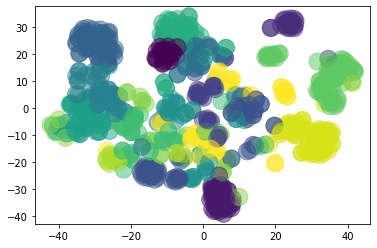

In [15]:
X = np.array(data['embediing_trf_mpnetv2'].tolist())

model = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)

Y=model.fit_transform(X)

plt.scatter(Y[:, 0], Y[:, 1], c=cluster_trf, s=290,alpha=.5)
plt.show()

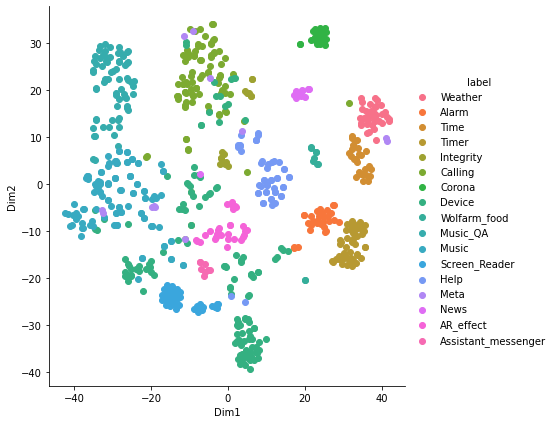

In [16]:
tnse_data=np.vstack((Y.T, data['Label'])).T
#tnse_data=np.vstack((Y.T, cluster_trf)).T
tsne_df=pd.DataFrame(data=tnse_data, columns=('Dim1','Dim2','label'))

sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim1', 'Dim2').add_legend()
plt.show()

In [18]:
pd.set_option('display.max_rows', 500)
df1=pd.DataFrame(data.groupby(['Label','cluster_trf_mpnetv2'])['cluster_trf_mpnetv2'].count())
df1.rename(columns = {'cluster_trf_mpnetv2':'Count'}, inplace = True)
df1

Count
Label               cluster_trf_mpnetv2       
AR_effect           3                        9
                    11                       6
                    13                       3
                    16                      11
Alarm               4                        2
                    11                       2
                    15                      26
Assistant_messenger 3                        1
                    6                        1
                    10                       2
                    14                       3
                    16                       1
Calling             0                       26
                    6                       16
                    8                        1
                    9                        1
                    10                      38
                    11                       3
                    12                       1
                    13                       2
                    16                       1
Corona              2                       21
Device              1                       45
                    3                        3
                    4                        3
                    6                       13
                    8                       27
                    9                        1
                    10                       2
                    11                      13
                    13                       4
                    14                      12
                    16                      10
Help                1                        1
                    3                        5
                    4                       29
                    6                        2
                    8                        4
                    9                        1
                    10                       1
                    11                       1
                    16                       7
Integrity           3                       12
                    6                        2
                    10                       2
Meta                9                        2
                    10                       3
                    11                       4
                    12                       1
                    15                       1
                    16                       1
Music               7                       30
                    9                       47
                    11                      22
                    13                      11
                    14                       1
Music_QA            5                       54
                    7                       16
                    9                        1
News                8                        1
                    12                      11
Screen_Reader       4                       34
                    8                        5
Time                12                      25
                    15                       1
Timer               15                      47
Weather             3                        1
                    12                      34
Wolfarm_food        16                      10

In [62]:
l2c = dict(zip(list(data.Label),data.cluster_trf_mpnetv2))
sorted(l2c.items())
clusters= [y for x,y in sorted(l2c.items()) ]
print(sorted(l2c.items()))

[('AR_effect', 3), ('Alarm', 15), ('Assistant_messenger', 14), ('Calling', 0), ('Corona', 2), ('Device', 8), ('Help', 4), ('Integrity', 3), ('Meta', 16), ('Music', 9), ('Music_QA', 5), ('News', 8), ('Screen_Reader', 4), ('Time', 12), ('Timer', 15), ('Weather', 12), ('Wolfarm_food', 16)]


In [65]:
#df4=data[data['Cluster_name'].isin(clusters)].sort_values('Label')
df_trf=data.sort_values('Label')
df_trf= pd.DataFrame(df_trf['cluster_trf_mpnetv2'].value_counts(sort=False))
df_trf.rename(columns = {'cluster_trf_mpnetv2':'Cluster_Count'}, inplace = True)
df_trf

,Cluster_Count
11,51
16,41
13,20
3,31
15,75
4,68
14,16
10,48
6,34
0,26


In [67]:
df_trf1=pd.DataFrame(data['Label'].value_counts()).sort_index()
df_trf1.rename(columns = {'Label':'Actual_Count'}, inplace = True)
df_trf1['Cluster_count']=[31,75,16,26,21,38,68,31,41,53,54,38,68,72,75,72,16]
df_trf1['Misclassified'] = abs(df_trf1['Actual_Count']-df_trf1['Cluster_count'])
df_trf1

,Actual_Count,Cluster_count,Misclassified
AR_effect,29,31,2
Alarm,30,75,45
Assistant_messenger,8,16,8
Calling,89,26,63
Corona,21,21,0
Device,133,38,95
Help,51,68,17
Integrity,16,31,15
Meta,12,41,29
Music,111,53,58


### Clustering by using KMean
#### Validating with silhouette analysis

In [21]:
# silhouette analysis
from sklearn.metrics import silhouette_score
range_n_clusters = [5, 7, 9, 11, 13, 15, 17, 19]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(list(data['embediing_trf_mpnetv2']))
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(list(data['embediing_trf_mpnetv2']), cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

For n_clusters=5, the silhouette score is 0.0685943216085434
For n_clusters=7, the silhouette score is 0.09391355514526367
For n_clusters=9, the silhouette score is 0.11862104386091232
For n_clusters=11, the silhouette score is 0.12448664754629135
For n_clusters=13, the silhouette score is 0.12297815084457397
For n_clusters=15, the silhouette score is 0.13878926634788513
For n_clusters=17, the silhouette score is 0.1406434178352356
For n_clusters=19, the silhouette score is 0.1454334557056427


In [21]:
from sklearn.model_selection import GridSearchCV
parameters={
            'init' : ['k-means++', 'random'],
            'algorithm' : ["auto", "full", "elkan"],
            'max_iter' : [50,100,200,300],
            'n_init' : [10,20,30]
    
            }
clustering_model = KMeans(n_clusters=num_clusters,n_jobs=-1)
grid = GridSearchCV(clustering_model, cv=5, param_grid = parameters, scoring = 
    silhouette_score)

grid.fit(list(data['embediing_trf_mpnetv2']))
print(grid.best_params_)

{'algorithm': 'auto', 'init': 'k-means++', 'max_iter': 50, 'n_init': 10}


In [22]:
# Perform kmean clustering
num_clusters = 17
clustering_model = KMeans(n_clusters=num_clusters,max_iter=50,n_jobs=-1,algorithm='auto',init='k-means++',n_init=10)
clustering_model.fit(list(data['embediing_trf_mpnetv2']))
cluster_assignment = clustering_model.labels_
data['k_means_clstr']=cluster_assignment

In [23]:
data.tail()

,Test Case Description,Label,cleaned_text,embediing_trf_mpnetv2,cluster_trf_mpnetv2,centroid_trf_mpnetv2,k_means_clstr
821,"\n From Ambient, IE not logged in: ""Hey Portal, join [room name]""\n",Assistant_messenger,from ambient ie not logged in join room name,"[-0.11604838, -0.091862194, -0.022614582, -0.031220106, 0.015762605, 0.04423539, -0.008306595, 0.025813432, 0.28952602, 0.022975206, -0.12763871, -0.06165539, -0.034085203, 0.18115625, 0.010170496...",6,"[-0.090056695, -0.08023642, 0.016023565, -0.017289544, 0.042313013, 0.004401861, -0.0048899725, -0.03999735, 0.039654076, 0.02446945, 0.06291866, -0.055517893, 0.049025152, 0.12252561, -0.11369464...",0
822,"\n ""Hey Portal, leave [room name for a room that doesn't exist] room""",Assistant_messenger,leave room name for a room that doesn t exist room,"[0.07240626, 0.006668695, -0.021002425, 0.02798616, -0.099413745, 0.07928688, 0.0754555, 0.028695177, 0.04122517, 0.23519896, -0.026586235, -0.04914814, -0.10775725, -0.09829057, 0.04339332, 0.040...",3,"[-0.0053307535, 0.02442007, 0.02798344, -0.058355957, 0.011417242, 0.05514703, -0.013171444, -0.00032063446, 0.16652301, 0.004985387, -0.031034585, 0.06616856, -0.016145216, 0.077293485, 0.0711843...",8
823,"\n ""Hey Portal, leave room""",Assistant_messenger,leave room,"[-0.07036097, -0.23025027, -0.055874594, -0.046697382, 0.042557374, 0.09836736, -0.13361533, 0.0857195, -0.07826443, 0.04898, 0.0057141054, -0.005977922, -0.13005713, 0.08855018, -0.087378554, 0.1...",14,"[-0.0971456, -0.22017641, -0.06390804, 0.012535659, 0.0071733985, 0.027874378, 0.067448154, -0.038987827, -0.18734182, 0.026642408, -0.10037392, 0.105529085, -0.044493742, 0.2328884, -0.048527416,...",8
824,"\n ""Hey Portal, leave room.""",Assistant_messenger,leave room,"[-0.07036097, -0.23025027, -0.055874594, -0.046697382, 0.042557374, 0.09836736, -0.13361533, 0.0857195, -0.07826443, 0.04898, 0.0057141054, -0.005977922, -0.13005713, 0.08855018, -0.087378554, 0.1...",14,"[-0.0971456, -0.22017641, -0.06390804, 0.012535659, 0.0071733985, 0.027874378, 0.067448154, -0.038987827, -0.18734182, 0.026642408, -0.10037392, 0.105529085, -0.044493742, 0.2328884, -0.048527416,...",8
825,"\n ""Hey Portal, end room.""",Assistant_messenger,end room,"[-0.031791285, -0.17827488, -0.099137366, -0.0701216, -0.06700171, 0.035030022, -0.23999521, 0.10410838, -0.010248788, 0.10615221, -0.0071197944, 0.11154033, -0.09448799, 0.01393409, 0.026743656, ...",14,"[-0.0971456, -0.22017641, -0.06390804, 0.012535659, 0.0071733985, 0.027874378, 0.067448154, -0.038987827, -0.18734182, 0.026642408, -0.10037392, 0.105529085, -0.044493742, 0.2328884, -0.048527416,...",7


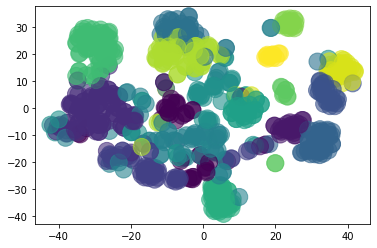

In [24]:
X = np.array(data['embediing_trf_mpnetv2'].tolist())

model = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)

Y=model.fit_transform(X)

plt.scatter(Y[:, 0], Y[:, 1], c=cluster_assignment, s=290,alpha=.6)
plt.show()

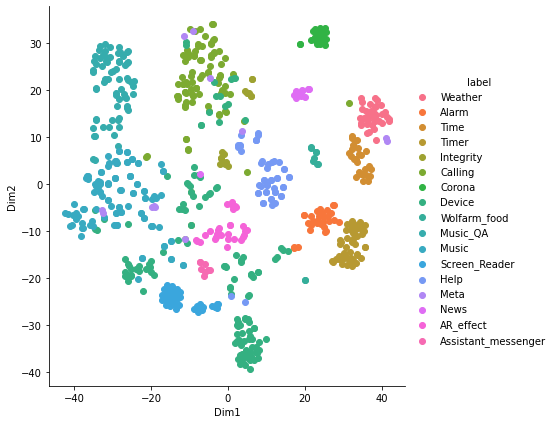

In [25]:
#tnse_data=np.vstack((Y.T, cluster_assignment)).T
tnse_data=np.vstack((Y.T, data['Label'])).T
tsne_df=pd.DataFrame(data=tnse_data, columns=('Dim1','Dim2','label'))

sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim1', 'Dim2').add_legend()
plt.show()

In [28]:
pd.set_option('display.max_rows', 500)
df1=pd.DataFrame(data.groupby(['Label','k_means_clstr'])['k_means_clstr'].count())
df1.rename(columns = {'k_means_clstr':'Count'}, inplace = True)
df1

Count
Label               k_means_clstr       
AR_effect           3                  1
                    7                 20
                    8                  8
Alarm               1                 28
                    5                  2
Assistant_messenger 0                  1
                    7                  2
                    8                  5
Calling             0                  2
                    6                 36
                    7                  5
                    8                  1
                    14                44
                    16                 1
Corona              7                  2
                    13                19
Device              0                 27
                    1                  1
                    2                  2
                    3                 20
                    6                  2
                    7                 18
                    8                  4
                    10                45
                    14                14
Help                0                  1
                    1                  1
                    7                  1
                    8                 11
                    9                 35
                    14                 1
                    15                 1
Integrity           6                  1
                    8                 13
                    14                 2
Meta                2                  5
                    4                  1
                    6                  3
                    7                  1
                    8                  1
                    15                 1
Music               2                 88
                    3                  6
                    7                  8
                    8                  9
Music_QA            2                  7
                    11                64
News                0                  1
                    16                11
Screen_Reader       0                  5
                    3                 34
Time                4                 26
Timer               5                 47
Weather             8                  1
                    15                34
Wolfarm_food        12                10

In [29]:
l2c = dict(zip(list(data.Label),data.k_means_clstr))
sorted(l2c.items())
clusters= [y for x,y in sorted(l2c.items()) ]
sorted(l2c.items())

[('AR_effect', 8),
 ('Alarm', 1),
 ('Assistant_messenger', 7),
 ('Calling', 14),
 ('Corona', 7),
 ('Device', 0),
 ('Help', 9),
 ('Integrity', 8),
 ('Meta', 8),
 ('Music', 2),
 ('Music_QA', 11),
 ('News', 0),
 ('Screen_Reader', 3),
 ('Time', 4),
 ('Timer', 5),
 ('Weather', 15),
 ('Wolfarm_food', 12)]

In [69]:
df3=pd.DataFrame(data['Label'].value_counts()).sort_index()

df3.rename(columns = {'Label':'Actual_Count'}, inplace = True)
df3

,Actual_Count
AR_effect,29
Alarm,30
Assistant_messenger,8
Calling,89
Corona,21
Device,133
Help,51
Integrity,16
Meta,12
Music,111


In [68]:
#df4=data[data['Cluster_name'].isin(clusters)].sort_values('Label')
df4=data.sort_values('Label')
df5= pd.DataFrame(df4['k_means_clstr'].value_counts(sort=False))
df5.rename(columns = {'k_means_clstr':'Cluster_Count'}, inplace = True)
df5

,Cluster_Count
7,57
8,53
3,61
1,30
5,49
0,37
6,42
14,61
16,12
13,19


In [48]:
df5.loc[df5.index[0]]['Cluster_Count']

57

In [33]:
print(sorted(l2c.items()))

[('AR_effect', 8), ('Alarm', 1), ('Assistant_messenger', 7), ('Calling', 14), ('Corona', 7), ('Device', 0), ('Help', 9), ('Integrity', 8), ('Meta', 8), ('Music', 2), ('Music_QA', 11), ('News', 0), ('Screen_Reader', 3), ('Time', 4), ('Timer', 5), ('Weather', 15), ('Wolfarm_food', 12)]


In [57]:
# c_cnt=[]
# for k,v in sorted(l2c.items()):
#     c_cnt.append(df5.loc[df5.index[v]]['Cluster_Count'])

            
        
        
# c_cnt

In [72]:
df3['Cluster_count']=[53,30,57,103,57,37,35,53,53,102,64,37,61,27,49,36,10]
df3['Misclassified'] = abs(df3['Actual_Count']-df3['Cluster_count'])
df3

,Actual_Count,Cluster_count,Misclassified
AR_effect,29,53,24
Alarm,30,30,0
Assistant_messenger,8,57,49
Calling,89,103,14
Corona,21,57,36
Device,133,37,96
Help,51,35,16
Integrity,16,53,37
Meta,12,53,41
Music,111,102,9


In [73]:
pd.set_option('display.max_rows', 500)
data[data['k_means_clstr']==14][['cleaned_text','Label','k_means_clstr']]

,cleaned_text,Label,k_means_clstr
140,emergency call,Integrity,14
141,call an ambulance,Integrity,14
156,call ira,Calling,14
160,call mom,Calling,14
171,commence call with emma,Calling,14
177,make a call,Calling,14
187,start a call with michelle,Calling,14
696,initiate a wa call,Device,14
697,cancel call,Device,14
699,end call,Device,14


### Saving the model

In [74]:
import pickle
import joblib

In [76]:
joblib.dump(clustering_model, 'model/cls_mpnetv2.pkl')

['model/cls_mpnetv2.pkl']

In [92]:
cls_model = joblib.load('model/cls_mpnetv2.pkl')
cls_model. predict(data.iloc[156]['embediing_trf_mpnetv2'].reshape(-1, 1))

ValueError: X has 1 features, but KMeans is expecting 768 features as input.

In [ ]:

 clustering_model.fit(list(data['embediing_trf_mpnetv2']))
cluster_assignment = clustering_model.labels_
data['k_means_clstr']=cluster_assignment
# Use the loaded model to make predictions
print(cls_model.predict(count_vect.transform(["how late is it in istanbul"])))